In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Function to read annotation data from the .cat files
def read_annotation_file(annotation_file_path):
    with open(annotation_file_path, 'r') as file:
        line = file.readline().strip()
        values = line.split()
        num_points = int(values[0])
        annotation_data = [int(value) for value in values[1:]]
        return num_points, annotation_data

# Path to the directory containing the images and .cat files
folder_path = r'C:\Users\haris\AI\ML\Projects\Data\CatFaceFeatures\Cats - Original'

# Lists to store paths of .jpg files and .cat files
image_files_path = []
annotation_files_path = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', 'png')):
            image_path = os.path.join(root, file)
            image_files_path.append(image_path)

        if file.lower().endswith('.cat'):
            annotation_path = os.path.join(root, file)
            annotation_files_path.append(annotation_path)

# Lists to store resized image data and annotation data
resized_images = []
resized_annotations = []

image_size = (224, 224)

# Read annotation data for each image and apply normalization
for annotation_file_path in annotation_files_path:
    num_points, annotation_data = read_annotation_file(annotation_file_path)

    image = cv2.imread(annotation_file_path[:-4], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, image_size)

    # Calculate the scaling factor for annotation coordinates
    scale_y = resized_image.shape[0] / image.shape[0]
    scale_x = resized_image.shape[1] / image.shape[1]

    # Apply scaling to the annotation data for both x and y coordinates together
    resized_annotation_data = [int(value * scale_x) if i % 2 == 0 else int(value * scale_y) for i, value in enumerate(annotation_data)]

    resized_images.append(resized_image)
    resized_annotations.append(resized_annotation_data)

# Convert lists to numpy arrays
resized_images = np.array(resized_images)
resized_annotations = np.array(resized_annotations)


In [3]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(resized_images, resized_annotations, test_size=0.1, random_state=42)

# Function to load and preprocess the images and annotations in batches
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x), np.array(batch_y)



Epoch 1/15
2250/2250 [==============================] - 234s 97ms/step - loss: 8998.6309 - mae: 87.1094 - val_loss: 7149.9033 - val_mae: 78.5019
Epoch 2/15
2250/2250 [==============================] - 219s 98ms/step - loss: 4050.1675 - mae: 55.1732 - val_loss: 1619.9590 - val_mae: 32.6658
Epoch 3/15
2250/2250 [==============================] - 219s 97ms/step - loss: 781.1686 - mae: 20.6157 - val_loss: 219.4146 - val_mae: 10.1643
Epoch 4/15
2250/2250 [==============================] - 221s 98ms/step - loss: 217.6016 - mae: 11.0470 - val_loss: 69.7247 - val_mae: 5.2485
Epoch 5/15
2250/2250 [==============================] - 219s 98ms/step - loss: 179.0233 - mae: 10.0744 - val_loss: 97.4591 - val_mae: 5.8277
Epoch 6/15
2250/2250 [==============================] - 220s 98ms/step - loss: 166.1602 - mae: 9.7564 - val_loss: 53.8582 - val_mae: 4.3362
Epoch 7/15
2250/2250 [==============================] - 220s 98ms/step - loss: 161.8890 - mae: 9.6441 - val_loss: 46.2556 - val_mae: 3.9659
Epoch

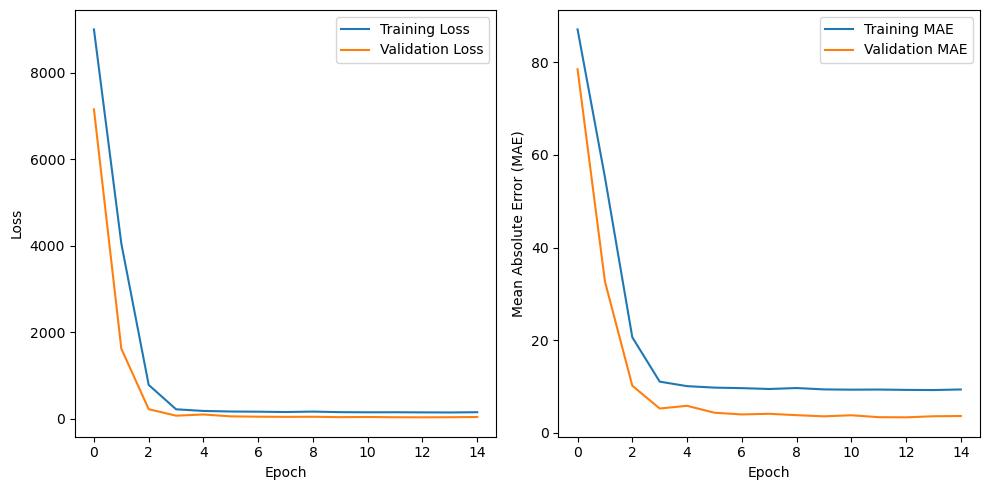

In [4]:
# Define the model with regularization
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(18, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze layers starting from a certain index (e.g., unfreeze layers from 100 onwards)
for layer in model.layers[100:]:
    layer.trainable = True


# Compile the model
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data generator
batch_size = 8
train_gen = DataGenerator(x_train, y_train, batch_size)
test_gen = DataGenerator(x_test, y_test, batch_size)

# Train the model with data generator
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=test_gen,
    callbacks=[early_stopping]
)

# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [5]:
# Save the trained model
model.save('CatFaceFeatures_Resnet50_2.h5')